# Лабораторная работа №1 — Baseline моделей KNN
# Автор: Пирязев М.А.
# Раздел: Создание бейзлайна и оценка качества (пункт 2)


In [43]:
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MultiLabelBinarizer, label_binarize, LabelBinarizer
from sklearn.model_selection import train_test_split

# Модели
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score

# Загрузка с Google Drive
import gdown

In [ ]:
bike_url = "https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5"
gdown.download(bike_url, "seoul_bike.csv", quiet=False)
bike_df = pd.read_csv("seoul_bike.csv", encoding="cp1252") 

# Датасет деталей
details_url = "https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk"
gdown.download(details_url, "details.csv", quiet=False)
details_df = pd.read_csv("details.csv")


Downloading...
From: https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5
To: /content/seoul_bike.csv
100%|██████████| 604k/604k [00:00<00:00, 55.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk
To: /content/details.csv
100%|██████████| 760k/760k [00:00<00:00, 102MB/s]


In [45]:
print("Bike dataset:")
display(bike_df.head())
display(bike_df.columns)

print("\nCar dataset:")
display(details_df.head())
display(details_df.columns)


Bike dataset:


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


Car dataset:


,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


Index(['ProductionVolume', 'ProductionCost', 'SupplierQuality',
       'DeliveryDelay', 'DefectRate', 'QualityScore', 'MaintenanceHours',
       'DowntimePercentage', 'InventoryTurnover', 'StockoutRate',
       'WorkerProductivity', 'SafetyIncidents', 'EnergyConsumption',
       'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost',
       'DefectStatus'],
      dtype='object')

In [46]:
# ==============================
# REGRESSION: BIKES
# ==============================

bike_df = bike_df.copy()
bike_df = bike_df.dropna()  # baseline: удаляем пропуски
print("Bike dataset shape after dropna:", bike_df.shape)

# Переводим дату в числовой формат
bike_df['Date'] = pd.to_datetime(bike_df['Date'], dayfirst=True)
bike_df['Date'] = bike_df['Date'].astype(int) // 10**9
print("Bike dataset 'Date' converted to int.")

# Кодируем категориальные признаки LabelEncoder
cat_cols_bike = bike_df.select_dtypes(include=['object']).columns
print("Bike categorical columns:", cat_cols_bike.tolist())

label_enc_bike = {}
for col in cat_cols_bike:
    le = LabelEncoder()
    bike_df[col] = le.fit_transform(bike_df[col].astype(str))
    label_enc_bike[col] = le
    print(f"Bike column '{col}' unique values after encoding:", bike_df[col].unique()[:5])

# Разделяем признаки и цель
bike_target = bike_df['Rented Bike Count']
bike_features = bike_df.drop(columns=['Rented Bike Count'])
print("Bike features shape:", bike_features.shape)
print("Bike target shape:", bike_target.shape)

# Масштабирование
scaler_bike = MinMaxScaler()
bike_features_scaled = scaler_bike.fit_transform(bike_features)
print("Bike features scaled. Shape:", bike_features_scaled.shape)


# ==============================
# CLASSIFICATION: DETAILS
# ==============================
# --- Разделяем признаки и целевую переменную ---
# Цель: 'DefectStatus' (0/1)
target_col = 'DefectStatus'
X = details_df.drop(columns=[target_col])
y = details_df[target_col]

print("Форма X:", X.shape)
print("Форма y:", y.shape)

# --- Простейший препроцессинг ---
# Удаляем пропуски (baseline)
X = X.fillna(0)  # на baseline просто заменяем на 0

# --- Масштабирование ---
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("Форма X после масштабирования:", X_scaled.shape)



Bike dataset shape after dropna: (8760, 14)
Bike dataset 'Date' converted to int.
Bike categorical columns: ['Seasons', 'Holiday', 'Functioning Day']
Bike column 'Seasons' unique values after encoding: [3 1 2 0]
Bike column 'Holiday' unique values after encoding: [1 0]
Bike column 'Functioning Day' unique values after encoding: [1 0]
Bike features shape: (8760, 13)
Bike target shape: (8760,)
Bike features scaled. Shape: (8760, 13)
Форма X: (3240, 16)
Форма y: (3240,)
Форма X после масштабирования: (3240, 16)


In [47]:
# Регрессия
X_train_bike, X_test_bike, y_train_bike, y_test_bike = train_test_split(
    bike_features_scaled, bike_target, test_size=0.2, random_state=42
)

# --- Разделение на train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.5, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1620, 16)
Test shape: (1620, 16)


In [48]:
knn_reg = KNeighborsRegressor()

knn_reg.fit(X_train_bike, y_train_bike)

y_pred_bike = knn_reg.predict(X_test_bike)

mae = mean_absolute_error(y_test_bike, y_pred_bike)
mse = mean_squared_error(y_test_bike, y_pred_bike)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_bike, y_pred_bike)

print("=== Baseline KNN Regression ===")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

=== Baseline KNN Regression ===
MAE: 181.09
MSE: 86913.66
RMSE: 294.81
R²: 0.7914


=== Минимальный Baseline KNN Classification ===
Accuracy: 0.8772
F1-score: 0.9325


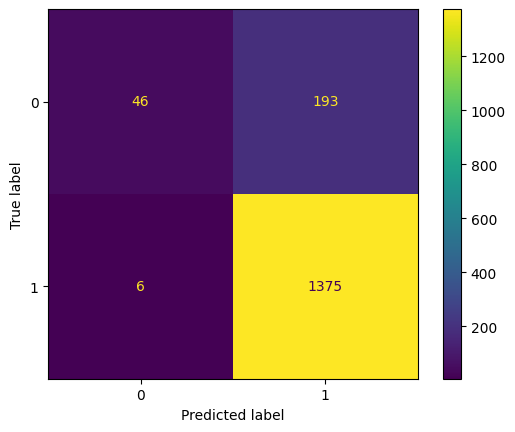

In [56]:


knn_clf = KNeighborsClassifier(n_neighbors=25)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== Минимальный Baseline KNN Classification ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
